In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings;warnings.filterwarnings('ignore')
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import  LabelEncoder

import optuna

In [2]:
train_path = './train.csv'
test_path  = './test.csv'
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [3]:
train['is_test'] = 0
test['is_test'] = 1
concat = pd.concat([train, test])

# 기준금리 추가하기

In [4]:
base_rate_path  = './기준금리.csv'
base_rate_df = pd.read_csv(base_rate_path)

In [5]:
# 월일 변수를 월과 일로 나누어주고 년 월 일을 합쳐 날짜를 8자리 정수로 표현하기
base_rate_df['년'] = base_rate_df['년'].map(lambda x: str(x))
base_rate_df['월'] = base_rate_df['월일'].map(lambda x : x[:2])
base_rate_df['일'] = base_rate_df['월일'].map(lambda x : x[4:6])
base_rate_df['날짜'] = base_rate_df['년'] + base_rate_df['월'] + base_rate_df['일']
base_rate_df['날짜'] = base_rate_df['날짜'].map(lambda x: int(x))
base_rate_df = base_rate_df[['날짜', '기준금리']]

In [6]:
# concat에 계약년월과 계약일을 합쳐 계약날짜 변수 생성 (8자리 정수)
concat['계약날짜'] = concat['계약년월'] * 100 + concat['계약일']

In [7]:
# concat의 '계약날짜' 값에 따라 '기준금리'를 반환해주는 함수.
def date_to_rate(date):
    for i in range(54, 0, -1): # 기준금리 데이터의 마지막 인덱스(54)에서 하나씩 올라가며 날짜를 비교하면서 기준금리 확인
        if date >= base_rate_df['날짜'][i] and date <base_rate_df['날짜'][i - 1]:
            return base_rate_df['기준금리'][i]
    return base_rate_df['기준금리'][0] # 날짜(date)가 기준금리 데이터의 가장 최신 날짜보다 같거나 크다면 가장 최신 기준금리 반환

# 예:
# date_to_rate(20211126)
# 1.0

In [8]:
# concat_new에 기준금리 변수 추가
concat['기준금리'] = concat['계약날짜'].apply(date_to_rate)

In [9]:
# '기준금리'열의 데이터 형식을 float로 변경
concat['기준금리'] = concat['기준금리'].astype(float)

In [10]:
# 추가된 변수 확인
concat[['계약날짜', '기준금리']]

,계약날짜,기준금리
0,20171208,1.5
1,20171222,1.5
2,20171228,1.5
3,20180103,1.5
4,20180108,1.5
...,...,...
9267,20230719,3.5
9268,20230725,3.5
9269,20230827,3.5
9270,20230902,3.5


# 전세가격지수 추가하기

In [11]:
jeonsae_path  = './아파트전세가격지수.csv'
jeonsae_df = pd.read_csv(jeonsae_path, encoding='cp949')

In [12]:
# 전세가격지수 데이터를 '년월'과 서울의 '전세가격지수'를 열로 가지는 데이터로 변환
data = {'년월':list(jeonsae_df.columns[1:]), '전세가격지수':list(jeonsae_df.iloc[1])[1:]}
seoul_jeonsae_df = pd.DataFrame(data)
seoul_jeonsae_df.head()

,년월,전세가격지수
0,2003.11,46.7
1,2003.12,46.2
2,2004.01,46.0
3,2004.02,46.3
4,2004.03,46.5


In [13]:
# 전세가격지수 데이터의 '년월' 형식을 concat의 '계약년월' 형식과 통일
seoul_jeonsae_df['년월'] = seoul_jeonsae_df['년월'].map(lambda x : int(x.split('.')[0]) * 100 + int(x.split('.')[1]))

In [14]:
# '전세가격지수' 변수가 추가된 concat 데이터
concat = pd.merge(concat, seoul_jeonsae_df, left_on='계약년월', right_on='년월', how='inner').drop('년월', axis=1)

In [15]:
# concat의 '전세가격지수'열의 형식을 float 변경
concat['전세가격지수'] = concat['전세가격지수'].astype(float)

In [16]:
# 확인을 위해 concat에서 랜덤으로 10개 샘플 뽑아보기
concat[['계약년월', '전세가격지수']].sample(n=10)

,계약년월,전세가격지수
637781,201512,88.1
510512,201611,90.4
73441,201710,92.3
206482,202306,83.5
243231,202012,97.2
212010,202304,83.5
93996,201805,92.3
117733,201201,69.1
202349,200901,52.1
1005277,201006,58.9


# 인구밀도 추가

In [17]:
population_density_path  = './인구밀도.csv'
population_density = pd.read_csv(population_density_path)

In [18]:
# 맨 위 row를 변수 이름으로 설정
population_density.columns = population_density.iloc[0]
population_density = population_density[1:]
population_density.head()

,동별(1),동별(2),동별(3),인구 (명),면적 (㎢),인구밀도 (명/㎢)
1,합계,소계,소계,9667669,605.21,15974
2,합계,종로구,소계,152211,23.91,6365
3,합계,종로구,사직동,9355,1.23,7606
4,합계,종로구,삼청동,2642,1.49,1773
5,합계,종로구,부암동,9536,2.27,4201


In [19]:
# concat의 '시군구' 변수에서 동을 분리하여 따로 변수 만들기
concat['동'] = concat['시군구'].map(lambda x : x.split()[2])

In [20]:
# 인구밀도 데이터 변수의 타입 변환
population_density_new = population_density[['동별(3)', '인구 (명)', '면적 (㎢)', '인구밀도 (명/㎢)']]
population_density_new['인구 (명)'] = population_density_new['인구 (명)'].astype(float)
population_density_new['면적 (㎢)'] = population_density_new['면적 (㎢)'].astype(float)
population_density_new['인구밀도 (명/㎢)'] = population_density_new['인구밀도 (명/㎢)'].astype(float)

In [21]:
# concat에서 동을 (유사)행정동으로 반환하는 함수
# '동'이 여러 행정동에 걸쳐있는 경우 임으로 걸쳐있는 행정동 중 하나로 선택하였음
def to_hangjungdong(dong):
    if dong in ['금호동1가']: 
        return '금호1가동'
    elif dong in ['봉천동']: # 중앙동은 5개의 동에 걸쳐있음
        return '중앙동'
    elif dong in ['마곡동']: # 마곡동은 가양1동, 방화1동, 발산1동에 걸쳐있음
        return '가양동'
    elif dong in ['내발산동']: # 내발산동은 '발산1동'과 '우장산동'에 걸쳐있음
        return '발산1동'
    elif dong in ['자곡동', '율현동']:
        return '세곡동'
    elif dong in ['금호동2가', '금호동3가']:
        return '금호2.3가동'
    elif dong in ['금호동4가']:
        return '금호4가동'
    elif dong in ['남대문로5가']:
        return '회현동'
    elif dong in ['남산동2가']:
        return '명동'
    elif dong in ['당산동1가', '당산동2가', '당산동3가']:
        return '당산1동'
    elif dong in ['당산동4가', '당산동5가', '당산동6가']:
        return '당산2동'
    elif dong in ['동선동1가', '동선동3가', '동선동4가', '동선동5가', '동소문동6가', '동소문동7가']:
        return '동선동'
    elif dong in ['동소문동5가', '삼선동2가', '삼선동3가', '삼선동4가', '삼선동5가']:
        return '삼선동'
    elif dong in ['만리동2가', '만리동1가']:
        return '중림동'
    elif dong in ['명륜1가', '명륜2가', '명륜3가']:
        return '혜화동'
    elif dong in ['문래동2가', '문래동3가', '문래동4가', '문래동5가', '문래동6가']:
        return '문래동'
    elif dong in ['보문동2가', '보문동3가', '보문동4가', '보문동6가']:
        return '보문동'
    elif dong in ['성북동1가', '동소문동', '동소문동4가']:
        return '성북동'
    elif dong in ['신문로1가', '신문로2가', '내수동', '당주동', '필운동']:
        return '사직동'
    elif dong in ['안암동1가', '안암동3가', '안암동4가', '안암동5가']:
        return '안암동'
    elif dong in ['양평동1가', '양평동2가', '양평동3가']: 
        return '양평1동'
    elif dong in ['양평동4가', '양평동5가', '양평동6가']: # '양평동3가'는 '양평1동'과 '양평2동'에 걸쳐있음 
        return '양평2동'
    elif dong in ['영등포동1가', '영등포동2가', '영등포동3가', '영등포동4가', '영등포동5가', '영등포동7가', '영등포동8가']:
        return '영등포동'
    elif dong in ['용산동2가']:
        return '용산2가동'
    elif dong in ['원효로1가', '원효로2가', '문배동', '신계동']: # 원효로1동, 2동의 인구밀도가 크게 차이나기 떄문에 두 개 분리
        return  '원효로1동'
    elif dong in ['원효로3가', '원효로4가', '산천동', '신창동', '청암동']:
        return '원효로2동'
    elif dong in ['을지로5가', '산림동', '입정동']:
        return '을지로동'
    elif dong in ['인현동2가', '오장동', '충무로4가', '충무로5가']: 
        return '광희동'
    elif dong in ['장충동1가', '장충동2가']:
        return '장충동'
    elif dong in ['청파동1가', '청파동3가']:
        return '청파동'
    elif dong in ['충정로2가', '충정로3가', '합동', '미근동']:
        return '충현동'
    elif dong in ['필동1가', '필동3가', '묵정동', '예장동']:
        return '필동'
    elif dong in ['한강로1가', '한강로2가', '한강로3가', '용산동5가']:
        return '한강로동'
    elif dong in ['회현동1가', '회현동2가', '남창동']:
        return '회현동'
    elif dong in ['천왕동']:
        return '오류동'
    elif dong in ['온수동', '궁동']:
        return '수궁동'
    elif dong in ['용두동', '신설동']:
        return '용신동'
    elif dong in ['본동']:
        return '노량진동'
    elif dong in ['동작동']:
        return '사당동'
    elif dong in ['노고산동']:
        return '대흥동'
    elif dong in ['마포동']:
        return '도화동'
    elif dong in ['상수동']:
        return '서강동'
    elif dong in ['신공덕동']:
        return '공덕동'
    elif dong in ['동교동']:
        return '연남동'
    elif dong in ['중동']:
        return '성산동'
    elif dong in ['창전동', '하중동']:
        return '서강동'
    elif dong in ['냉천동', '영천동', '현저동']:
        return '천연동'
    elif dong in ['토정동']:
        return '용강동'
    elif dong in ['현석동', '구수동']:
        return '신수동'
    elif dong in ['대현동', '창천동']:
        return '신촌동'
    elif dong in ['우면동']:
        return '양재동'
    elif dong in ['도선동', '상왕십리동', '하왕십리동', '홍익동']:
        return '왕십리도선동'
    elif dong in ['상월곡동', '하월곡동']:
        return '월곡동'
    elif dong in ['신천동']:
        return '잠실동'
    elif dong in ['여의도동']:
        return '여의동'
    elif dong in ['갈월동', '동자동']:
        return '남영동'
    elif dong in ['도원동']:
        return '용문동'
    elif dong in ['동빙고동', '주성동']:
        return '서빙고동'
    elif dong in ['익선동', '견지동', '인의동', '수송동', '원남동', '낙원동']:
        return '종로1.2.3.4가동'
    elif dong in ['효제동', '충신동', '연지동']:
        return '종로5.6가동'
    elif dong in ['교북동', '행촌동', '홍파동', '평동']:
        return '교남동'
    elif dong in ['누상동', '옥인동', '청운동', '통인동', '신교동']:
        return '청운효자동'
    elif dong in ['동숭동', '연건동']:
        return '이화동'
    elif dong in ['신영동']:
        return '부암동'
    elif dong in ['순화동', '정동']:
        return '소공동'
    elif dong in ['흥인동']:
        return '신당동'
    elif dong in ['구기동']:
        return '평창동'
    else:
        return dong
    

In [22]:
# concat의 '동'을 유사 행정동으로 변환
concat['동'] = concat['동'].apply(to_hangjungdong)

In [23]:
# 인구밀도 데이터의 몇 개의 행정동을 하나로 합쳐주기 위한 리스트
dong_merge_list = [['성수동1가', '성수1가1동','성수1가2동'],
                   ['성수동2가', '성수2가1동', '성수2가3동'],
                   ['논현동', '논현1동', '논현2동'],
                   ['대치동', '대치1동', '대치2동', '대치4동'],
                   ['도곡동', '도곡1동', '도곡2동'],
                   ['역삼동', '역삼1동', '역삼2동'],
                   ['일원동', '일원본동', '일원1동'],
                   ['고덕동', '고덕1동', '고덕2동'],
                   ['둔촌동', '둔촌1동', '둔촌2동'],
                   ['명일동', '명일1동', '명일2동'],
                   ['상일동', '상일1동', '상일2동'],
                   ['성내동', '성내1동', '성내2동', '성내3동'],
                   ['암사동', '암사1동', '암사2동', '암사3동'],
                   ['천호동', '천호1동', '천호2동', '천호3동'],
                   ['번동', '번1동', '번2동', '번3동'],
                   ['가양동', '가양1동', '가양2동', '가양3동'],
                   ['수유동', '수유1동', '수유2동', '수유3동'],
                   ['등촌동', '등촌1동', '등촌2동', '등촌3동'],
                   ['방화동', '방화1동', '방화2동', '방화3동'],
                   ['화곡동', '화곡1동', '화곡2동',  '화곡3동', '화곡4동', '화곡6동', '화곡8동', '화곡본동'],
                   ['구의동', '구의1동', '구의2동', '구의3동'],
                   ['자양동', '자양1동', '자양2동', '자양3동', '자양4동'],
                   ['개봉동', '개봉1동', '개봉2동', '개봉3동'],
                   ['고척동', '고척1동', '고척2동'],
                   ['중곡동', '중곡1동', '중곡2동', '중곡3동'],
                   ['구로동', '구로1동', '구로2동', '구로3동', '구로4동', '구로5동'],
                   ['개포동', '개포1동', '개포2동', '개포3동', '개포4동'],
                   ['오류동', '오류1동', '오류2동'],
                   ['독산동', '독산1동', '독산2동', '독산3동', '독산4동'],
                   ['시흥동', '시흥1동', '시흥2동', '시흥3동', '시흥4동', '시흥5동'],
                   ['공릉동', '공릉1동', '공릉2동'],
                   ['상계동', '상계1동', '상계2동', '상계5동', '상계8동', '상계9동', '상계10동', '상계3.4동', '상계6.7동'],
                   ['월계동', '월계1동', '월계2동', '월계3동'],
                   ['중계동', '중계본동', '중계1동', '중계4동', '중계2.3동'],
                   ['하계동', '하계1동', '하계2동'],
                   ['도봉동', '도봉1동', '도봉2동'],
                   ['방학동', '방학1동', '방학2동', '방학3동'],
                   ['쌍문동', '쌍문1동', '쌍문2동', '쌍문3동', '쌍문4동'],
                   ['창동', '창1동', '창2동', '창3동', '창4동', '창5동'],
                   ['답십리동', '답십리1동', '답십리2동'],
                   ['이문동', '이문1동', '이문2동'],
                   ['장안동', '장안1동', '장안2동'],
                   ['전농동', '전농1동', '전농2동'],
                   ['휘경동', '휘경1동', '휘경2동'],
                   ['노량진동', '노량진1동', '노량진2동'],
                   ['사당동', '사당1동', '사당2동', '사당3동', '사당4동', '사당5동'],
                   ['상도동', '상도1동', '상도2동', '상도3동', '상도4동'],
                   ['신대방동', '신대방1동', '신대방2동'],
                   ['성산동', '성산1동', '성산2동'],
                   ['신정동', '신정1동', '신정2동', '신정3동', '신정4동', '신정6동', '신정7동'],
                   ['망원동', '망원1동', '망원2동'],
                   ['남가좌동', '남가좌1동', '남가좌2동'],
                   ['북가좌동', '북가좌1동', '북가좌2동'],
                   ['홍은동', '홍은1동', '홍은2동'],
                   ['홍제동', '홍제1동', '홍제2동', '홍제3동'],
                   ['반포동', '반포본동', '반포1동', '반포2동', '반포3동', '반포4동'],
                   ['방배동', '방배본동', '방배1동', '방배2동', '방배3동', '방배4동'],
                   ['서초동', '서초1동', '서초2동', '서초3동', '서초4동'],
                   ['양재동', '양재1동', '양재2동'],
                   ['행당동', '행당1동', '행당2동'],
                   ['길음동', '길음1동', '길음2동'],
                   ['돈암동', '돈암1동', '돈암2동'],
                   ['장위동', '장위1동', '장위2동', '장위3동'],
                   ['정릉동', '정릉1동', '정릉2동', '정릉3동', '정릉4동'],
                   ['가락동', '가락본동', '가락1동', '가락2동'],
                   ['거여동', '거여1동', '거여2동'],
                   ['마천동', '마천1동', '마천2동'],
                   ['문정동', '문정1동', '문정2동'],
                   ['송파동', '송파1동', '송파2동'],
                   ['방이동',  '방이1동', '방이2동'],
                   ['잠실동', '잠실본동', '잠실2동', '잠실3동', '잠실4동', '잠실6동', '잠실7동'],
                   ['풍납동', '풍납1동', '풍납2동'],
                   ['목동', '목1동', '목2동', '목3동', '목4동'],
                   ['신월동', '신월1동', '신월2동', '신월3동', '신월4동', '신월5동', '신월6동', '신월7동'],
                   ['당산동', '당산1동', '당산2동'],
                   ['대림동', '대림1동', '대림2동', '대림3동'],
                   ['신길동', '신길1동', '신길3동', '신길4동', '신길5동', '신길6동', '신길7동'],
                   ['이촌동', '이촌1동', '이촌2동'],
                   ['이태원동', '이태원1동', '이태원2동'],
                   ['불광동', '불광1동', '불광2동'],
                   ['갈현동', '갈현1동', '갈현2동'],
                   ['응암동', '응암1동', '응암2동', '응암3동'],
                   ['숭인동', '숭인1동', '숭인2동'],
                   ['창신동', '창신1동', '창신2동', '창신3동'],
                   ['망우동', '망우본동', '망우3동'],
                   ['면목동', '면목본동', '면목2동', '면목4동', '면목5동', '면목7동', '면목3.8동'],
                   ['묵동', '묵1동', '묵2동'],
                   ['상봉동', '상봉1동', '상봉2동'],
                   ['신내동', '신내1동', '신내2동'],
                   ['중화동', '중화1동', '중화2동'],
                   ['월곡동', '월곡1동', '월곡2동']
                   ]

In [24]:
# 행정동을 합쳐 유사 행정동을 구하고 합친 인구와 면적을 사용하여 밀도를 다시 구하기
for dongs in dong_merge_list:
    dong_dict ={}
    dong_dict['동별(3)'] = dongs[0]
    dong_pop = 0
    dong_area = 0
    for dong in dongs[1:]:
        dong_pop += population_density_new.loc[population_density_new['동별(3)'] == dong, '인구 (명)'].values[0]
        dong_area += population_density_new.loc[population_density_new['동별(3)'] == dong, '면적 (㎢)'].values[0]
    dong_density = dong_pop / dong_area
    dong_dict['인구 (명)'] = dong_pop
    dong_dict['면적 (㎢)'] = dong_area
    dong_dict['인구밀도 (명/㎢)'] = dong_density
    population_density_new = population_density_new.append(dong_dict, ignore_index=True)
    

In [25]:
# '인구밀도 (명/㎢)' 변수가 추가된 concat 데이터
concat = pd.merge(concat, population_density_new, left_on='동', right_on='동별(3)', how='inner').drop(['동별(3)', '인구 (명)', '면적 (㎢)'], axis=1)

In [26]:
# 확인을 위해 concat에서 랜덤으로 10개 샘플 뽑아보기
concat[['동', '인구밀도 (명/㎢)']].sample(n=10)

,동,인구밀도 (명/㎢)
354025,가산동,10543.000000
1093300,황학동,40785.000000
934115,풍납동,15820.338983
194821,방화동,8502.490421
512705,쌍문동,26852.857143
451000,중계동,19837.500000
1060504,응암동,32800.000000
734168,방배동,14515.568862
68212,압구정동,10238.000000
330658,구로동,24740.264650


# 결측치 채우기

In [27]:
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

In [28]:
house_df_path = "./서울시 공동주택 아파트 정보.csv"
house_df = pd.read_csv(house_df_path, encoding='cp949')

In [29]:
# '도로명주소'을 기준으로 df_train의 결측치 ('아파트명'은 같은 아파트임에도 서로 일치하지 않는 항목이 많아서)
house_df['도로명주소'] = house_df['주소(도로명)'] + ' ' + house_df['주소(도로상세주소)']
house_df = house_df.drop_duplicates(subset='도로명주소')

In [30]:
# house_df_unique에서 '도로명주소'가 같은 경우 수치형인 열은 평균값으로, 범주형인 열은 최빈값으로 중복값 대체
def handle_duplicates(df):
    duplicates = df.duplicated(subset=['도로명주소'])
    for col in df.columns:
        if col != '도로명주소':
            if df[col].dtype == 'int64':
                df[col] = df.groupby('도로명주소')[col].transform(lambda x: x.mean() if not x.isnull().all() else x)
            else:
                df[col] = df.groupby('도로명주소')[col].transform(lambda x: x.mode().iloc[0] if not x.isnull().all() else x)
    df = df.drop_duplicates(subset=['도로명주소'])
    return df

house_df = handle_duplicates(house_df)

In [31]:
# concat과 house_df_unique에 공통으로 존재하는 열 찾기
common_cols = []
for col_1 in (concat.columns):
    for col_2 in list(list(house_df.columns)):
        if col_1 == col_2:
            common_cols.append(col_1)
            break
common_cols.remove('k-전화번호')
common_cols.remove('k-팩스번호')
common_cols.remove('k-홈페이지')

In [32]:
# concat의 결측치를 house_df_unique로 채우기
for col in common_cols:
    concat[col] = concat[col].fillna(concat['도로명'].map(house_df.set_index('도로명주소')[col]))
concat['아파트명'] = concat['아파트명'].fillna(concat['도로명'].map(house_df.set_index('도로명주소')['k-아파트명']))

In [33]:
# 결측치가 50만개 이상인 변수 제외
cols_selected = list(concat.columns[concat.isnull().sum() <= 500000])
concat_new = concat[cols_selected]
print(cols_selected)

['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_test', '계약날짜', '기준금리', '전세가격지수', '동', '인구밀도 (명/㎢)']


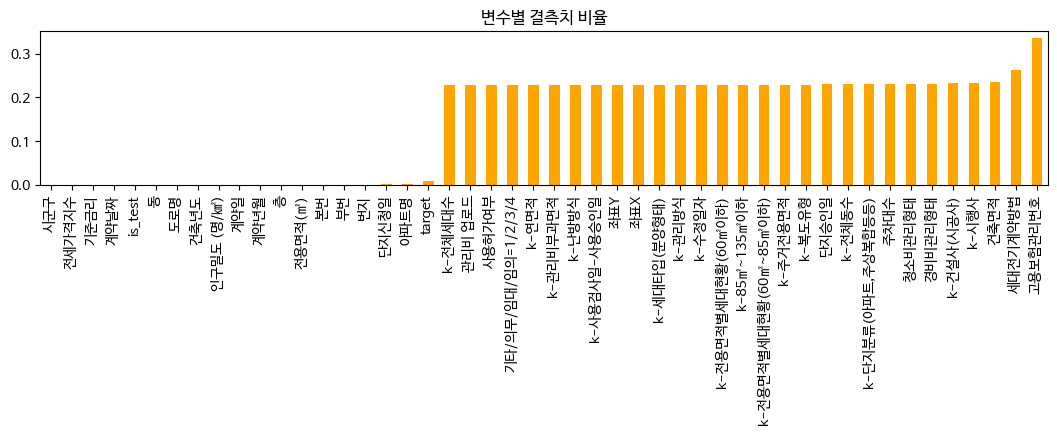

In [34]:
fig = plt.figure(figsize=(13, 2))
missing = concat_new.isnull().sum() / concat_new.shape[0]
missing = missing[missing >= 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

## 나머지 변수들의 결측치 채워주기

In [35]:
# # 도로명을 기준으로 수치형일 경우 평균으로 범주형일 경우 최빈값으로 채움
# for col in list(concat_new.columns):
#     if pd.api.types.is_numeric_dtype(concat_new[col]):
#         concat[col] = concat.groupby('도로명')[col].transform(lambda x: x.fillna(x.mean()) if not x.isnull().all() else x)
#     else:
#         concat[col] = concat.groupby('도로명')[col].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.isnull().all() else x)

# 아파트명 변수의 값을 단순화하기

In [36]:
concat_new['k-건설사(시공사)'] = concat_new['k-건설사(시공사)'].astype(str)

In [37]:
# 여러 건설사가 같이 시공하였을 시 더 브랜드 평판이 높은 건설사 혹은 데이터가 더 많은 건설사로 대체
def simple_apt(apt):
    if '현대건설' in apt or '힐스테이트' in apt:
        return '현대건설'
    elif '삼성물산' in apt:
        return '삼성물산'
    elif '대우건설' in apt or '푸르지오' in apt:
        return '대우건설'
    elif 'GS' in apt or 'gs' in apt or '지에스' in apt:
        return 'GS건설'
    elif '포스코' in apt:
        return '포스코건설'
    elif '래미안' in apt or '삼성물산' in apt:
        return '삼성물산'
    elif 'DL' in apt:
        return 'DL E&C'
    elif '롯데건설' in apt or '롯데캐슬' in apt:
        return '롯데건설'
    elif '현대산업' in apt:
        return '현대산업개발'
    elif '한화' in apt:
        return '한화건설'
    elif '쌍용' in apt:
        return '쌍용건설'
    elif apt in ['대한주택공사', 'LH공사', '한국토지주택공사', '한국주택공사', 'LH']:
        return '한국토지주택공사'
    elif '우성' in apt:
        return '우성건설'
    elif '한신' in apt:
        return '한신공영'
    elif '두산건설' in apt:
        return '두산건설'
    elif apt in ['동아건설', '(주)동아건설', '동아건설산업(주)', '동아건설산업', '동아건설(주)', '(주)동아건설산업', '동아,효성', '동아주택']:
        return '동아건설'
    elif '대림산업' in apt:
        return '대림산업'
    elif '벽산건설' in apt:
        return '벽산건설'
    elif '동부건설' in apt:
        return '동부건설'
    else:
        return 'Other'
    
    
concat_new['k-건설사(시공사)'] = concat_new['k-건설사(시공사)'].apply(simple_apt)
concat_new['k-건설사(시공사)'] = concat_new['k-건설사(시공사)'].fillna(value='Other') # 결측치도 'Other'로 통일

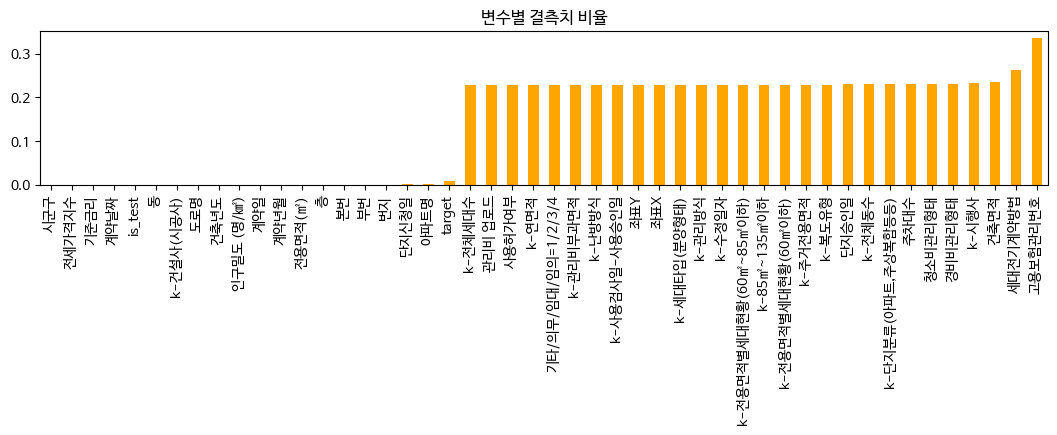

In [38]:
fig = plt.figure(figsize=(13, 2))
missing = concat_new.isnull().sum() / concat_new.shape[0]
missing = missing[missing >= 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

In [39]:
concat_new.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
       '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target',
       'is_test', '계약날짜', '기준금리', '전세가격지수', '동', '인구밀도 (명/㎢)'],
      dtype='object')

In [40]:
concat_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1133641 entries, 0 to 1133640
Data columns (total 48 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1133641 non-null  object 
 1   번지                      1133414 non-null  object 
 2   본번                      1133566 non-null  float64
 3   부번                      1133566 non-null  float64
 4   아파트명                    1131491 non-null  object 
 5   전용면적(㎡)                 1133641 non-null  float64
 6   계약년월                    1133641 non-null  int64  
 7   계약일                     1133641 non-null  int64  
 8   층                       1133641 non-null  int64  
 9   건축년도                    1133641 non-null  int64  
 10  도로명                     1133641 non-null  object 
 11  k-단지분류(아파트,주상복합등등)      872166 non-null   object 
 12  k-세대타입(분양형태)            874024 non-null   object 
 13  k-관리방식                  874024 non-null   object 
 14  k-

In [43]:
# 변수 타입 바꾸기
concat_new['좌표X'] = concat['좌표X'].astype(float)
concat_new['본번'] = concat['본번'].astype(float)
concat_new['부번'] = concat['부번'].astype(float)
concat_new['계약년월'] = concat['계약년월'].astype(str)
concat_new['좌표X'] = concat['좌표X'].astype(float)

# 간단한 모델 돌려보기

## 변수선택 

In [39]:
# concat_new = concat_new[['계약날짜','전세가격지수', '기준금리', '동', 'k-건설사(시공사)', '건축년도', '인구밀도 (명/㎢)', '전용면적(㎡)', '층', 'target', 'is_test']]
# cols_drop = ['시군구', '번지', '본번', '부번', '계약년월', '계약일', '도로명', ]

In [44]:
concat_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1133641 entries, 0 to 1133640
Data columns (total 48 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1133641 non-null  object 
 1   번지                      1133414 non-null  object 
 2   본번                      1133566 non-null  float64
 3   부번                      1133566 non-null  float64
 4   아파트명                    1131491 non-null  object 
 5   전용면적(㎡)                 1133641 non-null  float64
 6   계약년월                    1133641 non-null  object 
 7   계약일                     1133641 non-null  int64  
 8   층                       1133641 non-null  int64  
 9   건축년도                    1133641 non-null  int64  
 10  도로명                     1133641 non-null  object 
 11  k-단지분류(아파트,주상복합등등)      872166 non-null   object 
 12  k-세대타입(분양형태)            874024 non-null   object 
 13  k-관리방식                  874024 non-null   object 
 14  k-

In [45]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_new.query('is_test==0')
dt_test = concat_new.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1124347, 47) (9294, 47)


In [46]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

In [50]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['시군구', '번지', '본번', '부번', '전용면적(㎡)', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', '계약날짜', '기준금리', '전세가격지수', '인구밀도 (명/㎢)']
범주형 변수: ['아파트명', '계약년월', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', '동']


In [51]:
# 범주형 변수에 대한 보간
concat_new[categorical_columns] = concat_new[categorical_columns].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat_new[continuous_columns] = concat_new[continuous_columns].interpolate(method='linear', axis=0)

In [60]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

  0%|          | 0/22 [00:00<?, ?it/s]


TypeError: '<' not supported between instances of 'str' and 'float'

In [48]:
# 가격 로그 변환 후 원래 가격 따로 저장
dt_train['log_target'] = np.log1p(dt_train['target'])
real_target = dt_train['target'] # 원래 가격
dt_train.drop('target', axis=1, inplace=True)
dt_train.head(1)

,계약날짜,전세가격지수,기준금리,동,k-건설사(시공사),건축년도,인구밀도 (명/㎢),전용면적(㎡),층,log_target
0,20171208,92.7,1.5,27,8,1987,11824.116743,79.97,3,11.728045


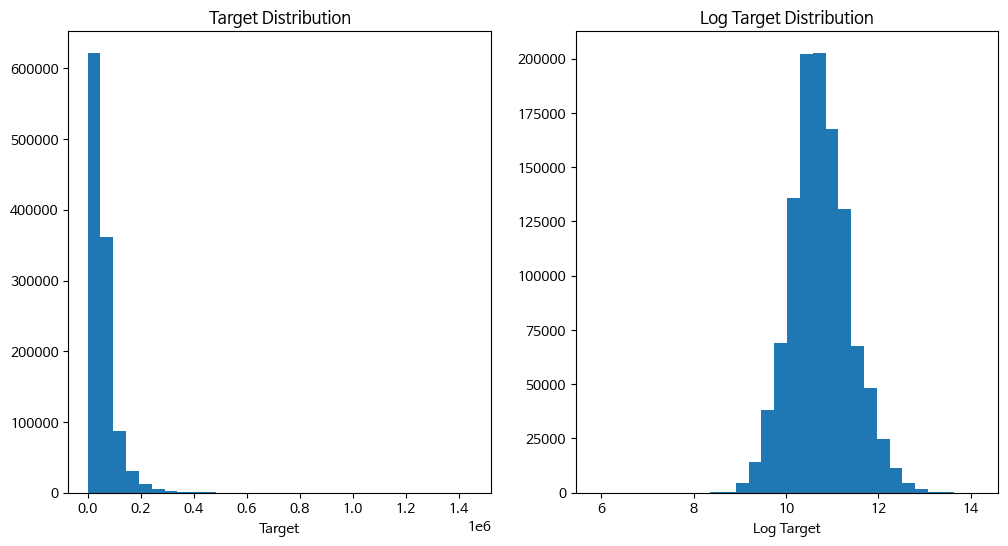

In [49]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.hist(real_target, bins=30)
ax1.set_title('Target Distribution')
ax1.set_xlabel('Target')

ax2.hist(dt_train['log_target'], bins=30)
ax2.set_title('Log Target Distribution')
ax2.set_xlabel('Log Target')

plt.show()

In [50]:
# 오히려 점수 높아짐
# dt_train = dt_train[dt_train['계약날짜'] > 20200000]

In [51]:
train_X, train_y = dt_train.drop('log_target', axis=1), dt_train['log_target']
print(train_X.shape, train_y.shape)

(1124347, 9) (1124347,)


In [52]:
dt_test.drop('target', axis=1, inplace=True)

## 하이퍼 파라미터 튜닝

### 모델별 성능 비교

In [53]:
def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

In [54]:
def rmse_cv(model):
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=10)
    rmse_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        rmse = RMSE(y_test, pred) 
        rmse_list.append(rmse)
    return model_name, rmse_list

In [55]:
def print_rmse_score(model):
    # cv별 프린팅, 평균 저장
    model_name, score = rmse_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} RMSLE: {r:.4f}')
    print(f'\n{model_name} mean RMSLE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)

In [61]:
# reg = LinearRegression(n_jobs=-1)
# ridge = Ridge(alpha=0.8, random_state=1)
# lasso = Lasso(alpha = 0.01, random_state=1)
# Enet = ElasticNet(alpha=0.03, l1_ratio=0.01, random_state=1)
# DTree = DecisionTreeRegressor(max_depth=6, min_samples_split=10, min_samples_leaf=15, random_state=1)
# rf = RandomForestRegressor(n_estimators=500, criterion='squared_error', max_depth=9, min_samples_split=50,
#                            min_samples_leaf=5, random_state=1, n_jobs=-1)
# model_xgb = xgb.XGBRegressor(n_estimators=500, max_depth=9, min_child_weight=5, gamma=0.1, n_jobs=-1)
# model_lgb = lgb.LGBMRegressor(n_estimators=500, max_depth=9, min_child_weight=5, n_jobs=-1)

In [62]:
# models = []
# scores = []
# for model in [reg, ridge, lasso, Enet, DTree, rf, model_xgb, model_lgb]:
#     model_name, mean_score = print_rmse_score(model)
#     models.append(model_name)
#     scores.append(mean_score)

LinearRegression Cross Validations...: 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


1 FOLDS: LinearRegression RMSLE: 0.2760
2 FOLDS: LinearRegression RMSLE: 0.2992
3 FOLDS: LinearRegression RMSLE: 0.2845
4 FOLDS: LinearRegression RMSLE: 0.2571
5 FOLDS: LinearRegression RMSLE: 0.2953
6 FOLDS: LinearRegression RMSLE: 0.3238
7 FOLDS: LinearRegression RMSLE: 0.3175
8 FOLDS: LinearRegression RMSLE: 0.3032
9 FOLDS: LinearRegression RMSLE: 0.3124
10 FOLDS: LinearRegression RMSLE: 0.3023

LinearRegression mean RMSLE: 0.2971


Ridge Cross Validations...: 100%|██████████| 10/10 [00:01<00:00,  7.06it/s]


1 FOLDS: Ridge RMSLE: 0.2760
2 FOLDS: Ridge RMSLE: 0.2992
3 FOLDS: Ridge RMSLE: 0.2845
4 FOLDS: Ridge RMSLE: 0.2571
5 FOLDS: Ridge RMSLE: 0.2953
6 FOLDS: Ridge RMSLE: 0.3238
7 FOLDS: Ridge RMSLE: 0.3175
8 FOLDS: Ridge RMSLE: 0.3032
9 FOLDS: Ridge RMSLE: 0.3124
10 FOLDS: Ridge RMSLE: 0.3023

Ridge mean RMSLE: 0.2971


Lasso Cross Validations...: 100%|██████████| 10/10 [00:21<00:00,  2.12s/it]


1 FOLDS: Lasso RMSLE: 0.2761
2 FOLDS: Lasso RMSLE: 0.2987
3 FOLDS: Lasso RMSLE: 0.2855
4 FOLDS: Lasso RMSLE: 0.2563
5 FOLDS: Lasso RMSLE: 0.2956
6 FOLDS: Lasso RMSLE: 0.3244
7 FOLDS: Lasso RMSLE: 0.3179
8 FOLDS: Lasso RMSLE: 0.3031
9 FOLDS: Lasso RMSLE: 0.3129
10 FOLDS: Lasso RMSLE: 0.3025

Lasso mean RMSLE: 0.2973


ElasticNet Cross Validations...: 100%|██████████| 10/10 [00:25<00:00,  2.54s/it]


1 FOLDS: ElasticNet RMSLE: 0.2760
2 FOLDS: ElasticNet RMSLE: 0.2991
3 FOLDS: ElasticNet RMSLE: 0.2846
4 FOLDS: ElasticNet RMSLE: 0.2570
5 FOLDS: ElasticNet RMSLE: 0.2953
6 FOLDS: ElasticNet RMSLE: 0.3238
7 FOLDS: ElasticNet RMSLE: 0.3175
8 FOLDS: ElasticNet RMSLE: 0.3032
9 FOLDS: ElasticNet RMSLE: 0.3124
10 FOLDS: ElasticNet RMSLE: 0.3023

ElasticNet mean RMSLE: 0.2971


DecisionTreeRegressor Cross Validations...: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


1 FOLDS: DecisionTreeRegressor RMSLE: 0.3090
2 FOLDS: DecisionTreeRegressor RMSLE: 0.2816
3 FOLDS: DecisionTreeRegressor RMSLE: 0.2733
4 FOLDS: DecisionTreeRegressor RMSLE: 0.2319
5 FOLDS: DecisionTreeRegressor RMSLE: 0.2608
6 FOLDS: DecisionTreeRegressor RMSLE: 0.3281
7 FOLDS: DecisionTreeRegressor RMSLE: 0.3273
8 FOLDS: DecisionTreeRegressor RMSLE: 0.2882
9 FOLDS: DecisionTreeRegressor RMSLE: 0.2989
10 FOLDS: DecisionTreeRegressor RMSLE: 0.2886

DecisionTreeRegressor mean RMSLE: 0.2888


RandomForestRegressor Cross Validations...: 100%|██████████| 10/10 [07:46<00:00, 46.66s/it]


1 FOLDS: RandomForestRegressor RMSLE: 0.2700
2 FOLDS: RandomForestRegressor RMSLE: 0.2411
3 FOLDS: RandomForestRegressor RMSLE: 0.2369
4 FOLDS: RandomForestRegressor RMSLE: 0.2179
5 FOLDS: RandomForestRegressor RMSLE: 0.2142
6 FOLDS: RandomForestRegressor RMSLE: 0.2909
7 FOLDS: RandomForestRegressor RMSLE: 0.2821
8 FOLDS: RandomForestRegressor RMSLE: 0.2688
9 FOLDS: RandomForestRegressor RMSLE: 0.2791
10 FOLDS: RandomForestRegressor RMSLE: 0.2587

RandomForestRegressor mean RMSLE: 0.2560


XGBRegressor Cross Validations...: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


1 FOLDS: XGBRegressor RMSLE: 0.2362
2 FOLDS: XGBRegressor RMSLE: 0.2437
3 FOLDS: XGBRegressor RMSLE: 0.2119
4 FOLDS: XGBRegressor RMSLE: 0.2250
5 FOLDS: XGBRegressor RMSLE: 0.1960
6 FOLDS: XGBRegressor RMSLE: 0.2870
7 FOLDS: XGBRegressor RMSLE: 0.2393
8 FOLDS: XGBRegressor RMSLE: 0.2445
9 FOLDS: XGBRegressor RMSLE: 0.2657
10 FOLDS: XGBRegressor RMSLE: 0.2445

XGBRegressor mean RMSLE: 0.2394


LGBMRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 849
[LightGBM] [Info] Number of data points in the train set: 102217, number of used features: 9
[LightGBM] [Info] Start training from score 11.188228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor Cross Validations...:  10%|█         | 1/10 [00:00<00:07,  1.13it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 877
[LightGBM] [Info] Number of data points in the train set: 204430, number of used features: 9
[LightGBM] [Info] Start training from score 10.907293


LGBMRegressor Cross Validations...:  20%|██        | 2/10 [00:02<00:08,  1.05s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 907
[LightGBM] [Info] Number of data points in the train set: 306643, number of used features: 9
[LightGBM] [Info] Start training from score 10.815320


LGBMRegressor Cross Validations...:  30%|███       | 3/10 [00:03<00:08,  1.26s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 925
[LightGBM] [Info] Number of data points in the train set: 408856, number of used features: 9
[LightGBM] [Info] Start training from score 10.705428


LGBMRegressor Cross Validations...:  40%|████      | 4/10 [00:05<00:08,  1.44s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 511069, number of used features: 9
[LightGBM] [Info] Start training from score 10.618363


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:07<00:08,  1.67s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 971
[LightGBM] [Info] Number of data points in the train set: 613282, number of used features: 9
[LightGBM] [Info] Start training from score 10.626435


LGBMRegressor Cross Validations...:  60%|██████    | 6/10 [00:09<00:07,  1.88s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 715495, number of used features: 9
[LightGBM] [Info] Start training from score 10.664519


LGBMRegressor Cross Validations...:  70%|███████   | 7/10 [00:12<00:06,  2.15s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1060
[LightGBM] [Info] Number of data points in the train set: 817708, number of used features: 9
[LightGBM] [Info] Start training from score 10.724128


LGBMRegressor Cross Validations...:  80%|████████  | 8/10 [00:15<00:04,  2.41s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1099
[LightGBM] [Info] Number of data points in the train set: 919921, number of used features: 9
[LightGBM] [Info] Start training from score 10.751489


LGBMRegressor Cross Validations...:  90%|█████████ | 9/10 [00:18<00:02,  2.66s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1138
[LightGBM] [Info] Number of data points in the train set: 1022134, number of used features: 9
[LightGBM] [Info] Start training from score 10.761341


LGBMRegressor Cross Validations...: 100%|██████████| 10/10 [00:21<00:00,  2.20s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
1 FOLDS: LGBMRegressor RMSLE: 0.2285
2 FOLDS: LGBMRegressor RMSLE: 0.2263
3 FOLDS: LGBMRegressor RMSLE: 0.2088
4 FOLDS: LGBMRegressor RMSLE: 0.2161
5 FOLDS: LGBMRegressor RMSLE: 0.1794
6 FOLDS: LGBMRegressor RMSLE: 0.2999
7 FOLDS: LGBMRegressor RMSLE: 0.2266
8 FOLDS: LGBMRegressor RMSLE: 0.2256
9 FOLDS: LGBMRegressor RMSLE: 0.2304
10 FOLDS: LGBMRegressor RMSLE: 0.2377

LGBMRegressor mean RMSLE: 0.2279


In [63]:
# result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
# result_df

,Model,Score
0,LinearRegression,0.297134
1,Ridge,0.297134
2,Lasso,0.297301
3,ElasticNet,0.297124
4,DecisionTreeRegressor,0.288771
5,RandomForestRegressor,0.255955
6,XGBRegressor,0.239393
7,LGBMRegressor,0.227927


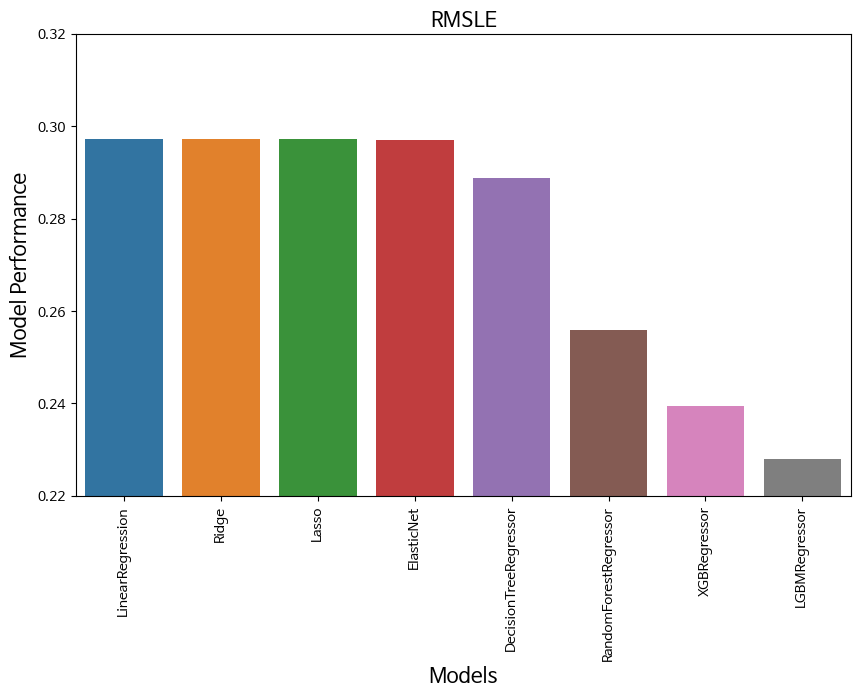

In [65]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='vertical')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.ylim(0.22, 0.32)
plt.title('RMSLE', fontsize=15)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

In [69]:
h_train_X, h_valid_X, h_train_y, h_valid_y = train_test_split(train_X, train_y, test_size=0.33, random_state=42)
print(h_train_X.shape, h_train_y.shape, h_valid_X.shape, h_valid_y.shape)

(899477, 9) (899477,) (224870, 9) (224870,)


In [74]:
from optuna.samplers import TPESampler

sampler = TPESampler(seed=10)

def objective(trial):
    dtrain = lgb.Dataset(h_train_X, label=h_train_y)
    dtest = lgb.Dataset(h_valid_X, label=h_valid_y)

    param = {
        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'rmse', 
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    model = lgb.LGBMRegressor(**param)
    lgb_model = model.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)])
    rmse = RMSE(h_valid_y, lgb_model.predict(h_valid_X))
    return rmse
        
study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective, n_trials=100)

[I 2024-01-22 01:40:42,360] A new study created in memory with name: no-name-0842b423-4ab7-4738-9169-6ffc31bc4857
[I 2024-01-22 01:40:58,442] Trial 0 finished with value: 0.6586543915437921 and parameters: {'max_depth': 13, 'learning_rate': 1.3320229150659043e-08, 'n_estimators': 1938, 'min_child_samples': 76, 'subsample': 0.6315909175774905}. Best is trial 0 with value: 0.6586543915437921.
[I 2024-01-22 01:41:16,359] Trial 1 finished with value: 0.658478386128041 and parameters: {'max_depth': 5, 'learning_rate': 1.5430400149097381e-07, 'n_estimators': 2306, 'min_child_samples': 21, 'subsample': 0.4337244827306443}. Best is trial 1 with value: 0.658478386128041.
[I 2024-01-22 01:41:17,443] Trial 2 finished with value: 0.43131206348705325 and parameters: {'max_depth': 11, 'learning_rate': 0.005252427629146827, 'n_estimators': 111, 'min_child_samples': 54, 'subsample': 0.8422371309477078}. Best is trial 2 with value: 0.43131206348705325.
[I 2024-01-22 01:41:25,585] Trial 3 finished with 

In [75]:
trial = study_lgb.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

Best Trial: score 0.22567953325363155,
params {'max_depth': 8, 'learning_rate': 0.002986900069055169, 'n_estimators': 2798, 'min_child_samples': 49, 'subsample': 0.5093682193591069}


## 모델 돌려보기

In [77]:
final_lgb_model = lgb.LGBMRegressor(**trial_params)
final_lgb_model.fit(train_X, train_y)
final_lgb_pred = final_lgb_model.predict(dt_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1241
[LightGBM] [Info] Number of data points in the train set: 1124347, number of used features: 9
[LightGBM] [Info] Start training from score 10.749419


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [78]:
pred_sub = np.expm1(final_lgb_pred)
pred_sub

array([184545.25576603, 258985.51467183, 191282.0904814 , ...,
        18742.69393451,  27106.95090916,  77848.28773507])

<BarContainer object of 9 artists>

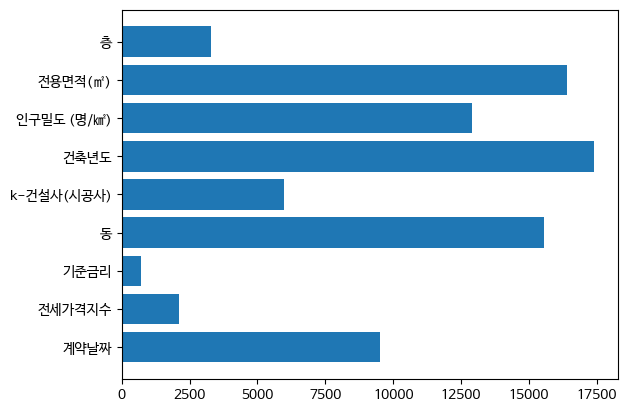

In [80]:
plt.barh(train_X.columns, final_lgb_model.feature_importances_)

In [79]:
pd.DataFrame(pred_sub.astype(int), columns=["target"]).to_csv('sub.csv', index=False)

In [ ]:
# pred = lgb.LGBMRegressor().fit(train_X, train_y).predict(dt_test)
# pred_sub = np.expm1(pred)
# pred_sub


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1122
[LightGBM] [Info] Number of data points in the train set: 157434, number of used features: 9
[LightGBM] [Info] Start training from score 11.228577


array([196561.07204421, 298566.10485355, 209399.96808015, ...,
        16391.63262673,  22038.20735366, 109595.57731075])

In [ ]:
# pd.DataFrame(pred_sub.astype(int), columns=["target"]).to_csv('sub.csv', index=False)